In [1]:
%config IPCompleter.greedy=True

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import variational_autoencoder as vae

print("Tensor Flow version {}".format(tf.__version__))

D:\z_outsourced_programs\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensor Flow version 1.8.0


In [3]:
#test utils
import weapon_data as weapons

def print_decoded_tensors_as_dict(weapon_data, array_of_tensors):
    genDict = {}
    
    for tensor in array_of_tensors:
        decoded = weapon_data.decode_processed_tensor(tensor)
        
        for key, value in decoded.items():
            if key not in genDict:
                genDict[key] = []
            genDict[key].append(value)
    
    for key, value in genDict.items():
            print(key, "=", value)
            
def get_weapon_data():
    return weapons.get_data(3, 15, 1)

In [4]:
import weapon_data as weapons

network_architecture = \
    dict(n_input=0, #set it in with scope
         n_hidden_1=14,
         n_hidden_2=15,
         n_z=2)  

learning_rate = 0.01
optimizer =  tf.train.AdamOptimizer(learning_rate)
#optimizer = tf.train.RMSPropOptimizer(learning_rate)
transfer_fct = lambda x : tf.nn.tanh(x)
num_epochs = 10
batch_size = 1
epoch_debug_step = 1
    
with tf.Session() as sess:
    weapon_data = get_weapon_data()
    network_architecture['n_input'] = weapon_data.num_features
  
    network = vae.get_new_trained(sess, weapon_data, network_architecture, optimizer, 
                              transfer_fct, batch_size, num_epochs, epoch_debug_step, )


Epoch:0001, cost=24.966059962
Epoch:0002, cost=22.324003452
Epoch:0003, cost=21.411929443
Epoch:0004, cost=20.743528685
Epoch:0005, cost=20.225995583
Epoch:0006, cost=19.325616083
Epoch:0007, cost=19.301444801
Epoch:0008, cost=19.278015233
Epoch:0009, cost=18.798632113
Epoch:0010, cost=19.280941212
Trained model saved! You can find it in './trained_vae/model.ckpt'


In [5]:
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, "trained_vae/model.ckpt")
        
    weapon_data = get_weapon_data()
    samples = weapon_data.next_batch(batch_size)
    x_reconstructed = network.encode_and_decode(samples)
    
    print(samples)
    print(x_reconstructed)
    
    print_decoded_tensors_as_dict(weapon_data, np.concatenate((samples,x_reconstructed), axis=0))

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
[[ 0.57455492 -0.70326645 -0.48674743 -0.30162464 -0.29826301 -0.22336265
   1.3003496  -0.75793673 -0.59816232  0.19378264 -1.11913753 -0.86609068
  -0.28002455  0.55030494  2.19514536  3.58362519  0.55859823 -0.28577464
  -0.32322997 -0.50421948 -0.54611868 -0.36023741 -0.52522573  2.45919073
  -0.2672411 ]]
[[-0.01771249 -0.872924   -0.584317   -0.3309797  -0.6370051  -0.25324634
   1.6034385  -0.9559141  -0.6911563   1.3573686  -0.7205461  -0.9235662
  -0.15986642  0.23999609  0.83162403  0.34357196  1.4537512  -0.21630365
  -0.42652544 -0.4870184  -0.22112171  1.011781   -0.5936212   0.88827145
  -0.22868529]]
damages_first = ['26.5', '22.300446526861176']
damages_last = ['20.0', '17.659855771315883']
dmg_distances_first = ['11.0', '10.563702821503544']
dmg_distances_last = ['50.0', '35.87422458401922']
drag = ['0.0024999999441206455', '0.0024638404818858404']
firemode_Automatic = ['1.0', '1.1464640791636']
firemode_

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt


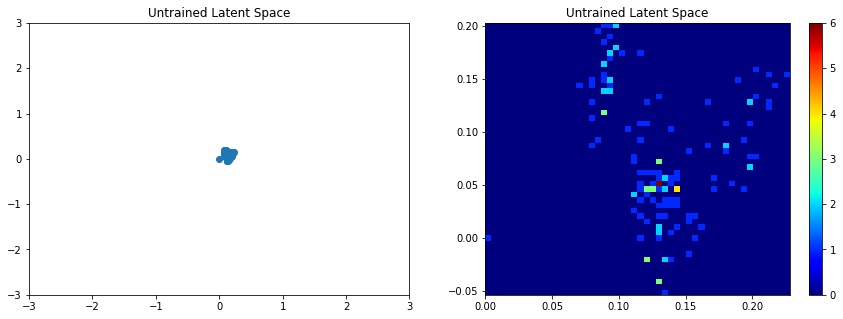

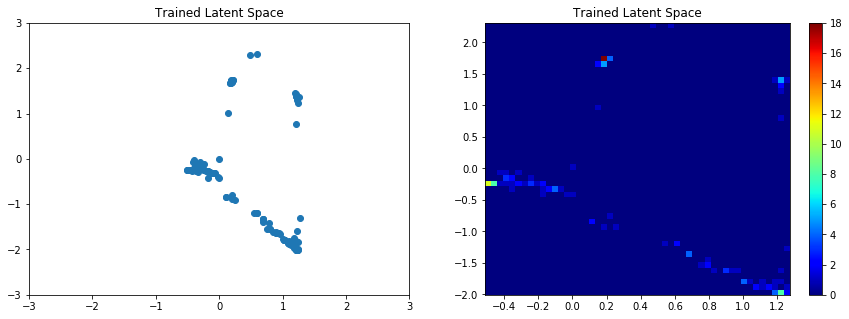

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_z_distribution(vae_model, title, z_mean=True):
    all_z = np.zeros((1,network_architecture['n_z']))
        
    weapon_data = get_weapon_data()
    total_batch = int(weapon_data.num_examples / batch_size) 

    # Loop over all batches
    for i in range(total_batch):
        batch = weapon_data.next_batch(batch_size)
        z_dist = vae_model.calculate_z(batch)
        if z_mean:
            z_dist = vae_model.calculate_z_mean(batch)
        all_z = np.vstack((all_z, z_dist))

    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.scatter(all_z[:,0], all_z[:,1])
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.title(title)
    plt.subplot(1,2,2)
    plt.hist2d(all_z[:,0], all_z[:,1], (50, 50), cmap=plt.cm.jet)
    plt.colorbar()
    plt.title(title)
    
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    show_z_distribution(network, "Untrained Latent Space", z_mean=True)
    network = vae.restore(network, "trained_vae/model.ckpt")
    show_z_distribution(network, "Trained Latent Space", z_mean=True)

In [7]:
# Testing
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, "trained_vae/model.ckpt")
    
    generated = []
    for i in range(4):
        random_val = np.random.normal(size=(1,network_architecture["n_z"]))
        x_test = network.decode_from_latent_space(random_val)
        generated.append(x_test[0])
        
    weapon_data = get_weapon_data()
    print_decoded_tensors_as_dict(weapon_data, generated)

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
damages_first = ['41.87885356158407', '23.562920670447447', '41.71888541301121', '54.92813870628801']
damages_last = ['22.700581747068032', '18.05944743641496', '22.541877021770556', '33.86883976895424']
dmg_distances_first = ['22.740344919002506', '10.913183460507451', '22.876762999748905', '20.62263914478904']
dmg_distances_last = ['49.33389846338657', '36.94993020315776', '49.1580902411299', '67.064639999771']
drag = ['0.002419778073912136', '0.002424856978771294', '0.002427760503164194', '0.0024971493161846095']
firemode_Automatic = ['0.12210401265847118', '1.1016389356806084', '0.1057675113032237', '-0.05917079233385664']
firemode_Semi-Automatic = ['0.7740791886895211', '-0.06338777937196838', '0.7881570549816782', '0.7138661924586145']
hiprecoildec = ['5.160375086781724', '9.023148044658974', '5.141256874467202', '4.270926220056471']
hiprecoilright = ['0.5292272951799343', '0.31694774675682064', '0.5309062953848787'